In [109]:
%pip install pandas numpy matplotlib seaborn scipy cvxpy openpyxl scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [110]:
import pandas as pd

# Load the Excel file
file_path = 'data/data2023.xlsx'

# Since the file has multiple sheets, let's list all sheet names to understand its structure
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

# Display the sheet names
sheet_names

# Remove unnecessary header row and set the first row as the header
deposits_ir_df = pd.read_excel(xls, sheet_name='DEPOSITS_IR')

# Replace ".." with NaN to indicate missing values
deposits_ir_df.replace("..", pd.NA, inplace=True)

# Check the cleaned DataFrame
deposits_ir_df.head()

,Country,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,"Bahamas, The",1.680000,1.417500,1.405000,1.241667,0.994167,0.840833,0.588333,0.452292,0.521958,0.517500,0.54
1,Barbados,2.510833,2.509167,1.322500,0.347500,0.194889,0.150278,0.150000,0.150000,0.150000,0.143333,0.15
2,Belize,3.585000,2.897061,2.600597,2.297762,2.119429,1.999167,1.950833,2.180000,2.229167,2.222385,2.08
3,Fiji,1.112000,1.169002,2.458025,2.771957,3.250544,3.444878,4.677639,2.894853,2.577054,1.546115,1.20
4,Mauritius,6.812500,6.784167,6.085833,5.154167,3.054167,3.343333,3.745833,1.720833,0.705000,1.216667,4.58


        Country  2013    2014   2015      2016      2017      2018      2019  \
0  Bahamas, The  1.68  1.4175  1.405  1.241667  0.994167  0.840833  0.588333   

       2020      2021    2022  2023  
0  0.452292  0.521958  0.5175  0.54  
               Country      2013      2014      2015      2016      2017  \
1             Barbados  2.510833  2.509167  1.322500  0.347500  0.194889   
2               Belize  3.585000  2.897061  2.600597  2.297762  2.119429   
3                 Fiji  1.112000  1.169002  2.458025  2.771957  3.250544   
4            Mauritius  6.812500  6.784167  6.085833  5.154167  3.054167   
5           Seychelles  3.428836  2.333050  3.161291  3.487662  3.607411   
6              Grenada  2.640460  2.399541  1.827667  1.540000  1.447500   
7  Antigua and Barbuda  3.044349  2.893394  2.466167  1.927500  1.755000   

       2018      2019      2020      2021      2022  2023  
1  0.150278  0.150000  0.150000  0.150000  0.143333  0.15  
2  1.999167  1.950833  2.180000  2

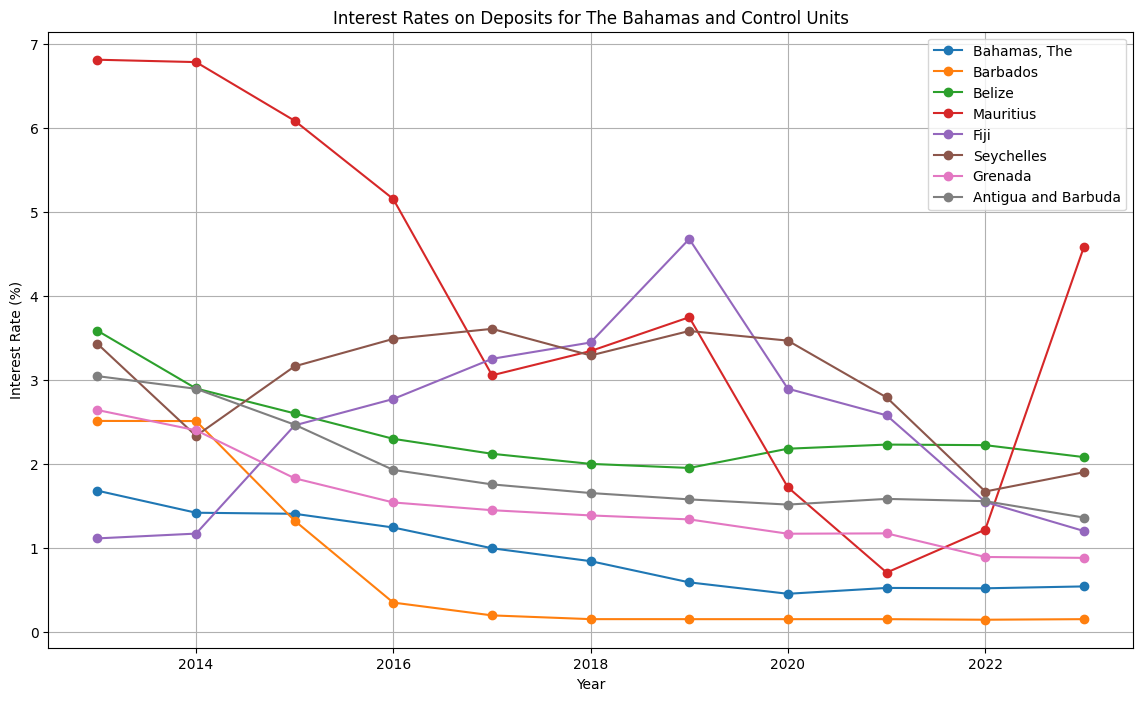

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of potential control units plus The Bahamas for checking data availability
countries_to_check = ['Bahamas, The', 'Barbados', 'Belize', 'Mauritius', 'Fiji', 'Seychelles', 'Grenada', 'Antigua and Barbuda']

# Filter the dataset for these countries
deposits_ir_countries = deposits_ir_df[deposits_ir_df['Country'].isin(countries_to_check)]

treatment_units = ['Bahamas, The']
treatment_units_df = deposits_ir_df[deposits_ir_df['Country'].isin(treatment_units)]
print(treatment_units_df)

control_units = ['Barbados', 'Belize', 'Mauritius', 'Fiji', 'Seychelles', 'Grenada', 'Antigua and Barbuda']
control_units_df = deposits_ir_df[deposits_ir_df['Country'].isin(control_units)]
print(control_units_df)

# Pivot the DataFrame for plotting: countries as series, years as x-axis
deposits_ir_countries_pivot = deposits_ir_countries.set_index('Country').T
deposits_ir_countries_pivot.index.name = 'Year'
deposits_ir_countries_pivot.columns.name = None

# Convert index to datetime to facilitate plotting (if necessary)
deposits_ir_countries_pivot.index = pd.to_datetime(deposits_ir_countries_pivot.index, format='%Y')

# Plot the data
plt.figure(figsize=(14, 8))
for country in treatment_units + control_units:
    plt.plot(deposits_ir_countries_pivot.index, deposits_ir_countries_pivot[country], marker='o', label=country)

plt.title('Interest Rates on Deposits for The Bahamas and Control Units')
plt.xlabel('Year')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
# Correcting the approach to access the data
# It appears there was an error in how the year columns were being accessed. They should be accessed as strings.
# Let's retry accessing the pre-intervention data with the corrected column references.

# Ensure that year columns are treated as strings for both extraction and analysis
pre_intervention_years = [int(year) for year in range(2013, 2020)]
post_intervention_years = [int(year) for year in range(2020, 2024)]

# Re-extracting pre-intervention data for The Bahamas using the corrected column names
treatment_pre_intervention = treatment_units_df.set_index('Country').loc[:, pre_intervention_years]
print(treatment_pre_intervention)

treatment_post_intervention = treatment_units_df.set_index('Country').loc[:, post_intervention_years]
print(treatment_post_intervention)

# Control units data was previously extracted correctly, but let's ensure it's correctly formatted for analysis
control_pre_intervention = control_units_df.set_index('Country').loc[:, pre_intervention_years]
print(control_pre_intervention)

control_post_intervention = control_units_df.set_index('Country').loc[:, post_intervention_years]
print(control_post_intervention)

              2013    2014   2015      2016      2017      2018      2019
Country                                                                  
Bahamas, The  1.68  1.4175  1.405  1.241667  0.994167  0.840833  0.588333
                  2020      2021    2022  2023
Country                                       
Bahamas, The  0.452292  0.521958  0.5175  0.54
                         2013      2014      2015      2016      2017  \
Country                                                                 
Barbados             2.510833  2.509167  1.322500  0.347500  0.194889   
Belize               3.585000  2.897061  2.600597  2.297762  2.119429   
Fiji                 1.112000  1.169002  2.458025  2.771957  3.250544   
Mauritius            6.812500  6.784167  6.085833  5.154167  3.054167   
Seychelles           3.428836  2.333050  3.161291  3.487662  3.607411   
Grenada              2.640460  2.399541  1.827667  1.540000  1.447500   
Antigua and Barbuda  3.044349  2.893394  2.466167  1.

In [114]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Conducting the synthetic control analysis involves finding weights for control units
# that minimize the difference in pre-intervention interest rates between The Bahamas and the synthetic control

# Setting up a linear regression model with no intercept to estimate weights for control units
# These weights will be constrained to sum to 1 in the synthetic control construction
model = LinearRegression(fit_intercept=False, positive=True)

# The independent variables are the control units' pre-intervention data
# The dependent variable is The Bahamas' pre-intervention data
x = control_pre_intervention.T.values
y = treatment_pre_intervention.T.values
print(x)
print(y)

# Adding a constraint that the sum of weights equals 1 by adding an additional observation
x = np.vstack([x, np.ones(x.shape[1])])
y = np.append(y, 1)

# Fitting the model
model.fit(x, y)

# Extracting the weights for the control units
weights = model.coef_

# Creating a synthetic The Bahamas based on the weights obtained
synthetic_treatment_pre_intervention = np.dot(control_pre_intervention.T, weights)

# Displaying the weights for transparency
control_units_weights = pd.Series(weights, index=control_pre_intervention.index)
control_units_weights

[[2.510833 3.585    1.112    6.8125   3.428836 2.64046  3.044349]
 [2.509167 2.897061 1.169002 6.784167 2.33305  2.399541 2.893394]
 [1.3225   2.600597 2.458025 6.085833 3.161291 1.827667 2.466167]
 [0.3475   2.297762 2.771957 5.154167 3.487662 1.54     1.9275  ]
 [0.194889 2.119429 3.250544 3.054167 3.607411 1.4475   1.755   ]
 [0.150278 1.999167 3.444878 3.343333 3.290765 1.385335 1.652086]
 [0.15     1.950833 4.677639 3.745833 3.581958 1.338253 1.57649 ]]
[[1.68    ]
 [1.4175  ]
 [1.405   ]
 [1.241667]
 [0.994167]
 [0.840833]
 [0.588333]]


Country
Barbados               0.014303
Belize                 0.000000
Fiji                   0.000000
Mauritius              0.000000
Seychelles             0.000000
Grenada                0.460487
Antigua and Barbuda    0.159077
dtype: float64

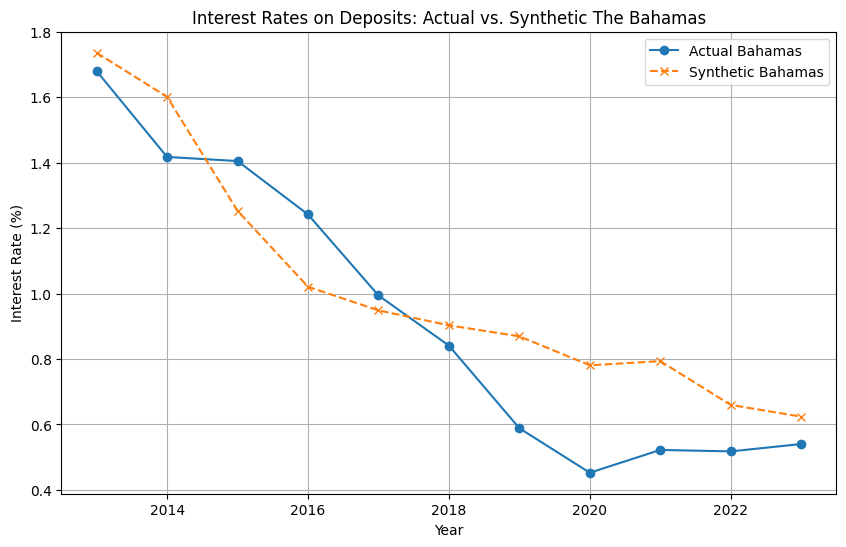

Difference between actual and synthetic The Bahamas post-treatment: [[-0.32844401 -0.34108634 -0.20726024 -0.17142636]
 [-0.25877801 -0.27142034 -0.13759424 -0.10176036]
 [-0.26323601 -0.27587834 -0.14205224 -0.10621836]
 [-0.24073601 -0.25337834 -0.11955224 -0.08371836]]


In [116]:

# Assuming 'post_treatment_period' contains the years after the CBDC introduction
# and 'control_post_intervention' is a DataFrame of the control units' post-intervention data

# Predict post-treatment interest rates for synthetic The Bahamas
synthetic_post_treatment = np.dot(control_post_intervention.T, weights)

# Concatenate pre and post intervention data for both actual and synthetic The Bahamas for plotting
actual_data = np.concatenate([treatment_pre_intervention.T, treatment_post_intervention.T])
synthetic_data = np.concatenate([synthetic_treatment_pre_intervention, synthetic_post_treatment])

# Time period for plotting
years = np.concatenate([pre_intervention_years, post_intervention_years])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, actual_data, label='Actual Bahamas', marker='o')
plt.plot(years, synthetic_data, label='Synthetic Bahamas', linestyle='--', marker='x')
plt.title('Interest Rates on Deposits: Actual vs. Synthetic The Bahamas')
plt.ylabel('Interest Rate (%)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

# Analyze the results
# Here you might calculate the mean absolute error, mean squared error, or simply discuss the observed differences
difference_post_treatment = actual_data[len(pre_intervention_years):] - synthetic_post_treatment
print("Difference between actual and synthetic The Bahamas post-treatment:", difference_post_treatment)

In [117]:
from sklearn.utils import shuffle

np.random.seed(42)  # For reproducibility

# Example of a simple permutation test
n_permutations = 1000
perm_diffs = []

for i in range(n_permutations):
    # Randomly shuffle the treatment labels
    shuffled_actual = shuffle(actual_data[len(pre_intervention_years):])
    perm_diff = np.mean(shuffled_actual) - np.mean(synthetic_post_treatment)
    perm_diffs.append(perm_diff)

# Calculate the p-value
obs_diff = np.mean(difference_post_treatment)
p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
print(f"P-value: {p_value}")


P-value: 1.0


A p-value of 1.0 in the context of the permutation test implies that, under the null hypothesis (which assumes there is no effect of the treatment), the observed difference in means between the actual and synthetic post-treatment data for The Bahamas is not statistically significant. In simpler terms, it suggests that the effect observed in the analysis could very likely have occurred by chance.

In permutation tests, the p-value is calculated as the proportion of times the permuted differences (differences calculated with shuffled labels, under the null hypothesis of no treatment effect) are as extreme as or more extreme than the observed difference. A p-value of 1.0 means that every permutation resulted in a difference as large as or larger than the one observed in your actual data, indicating no evidence against the null hypothesis.

No Clear Evidence of Treatment Effect: This result does not provide evidence to reject the null hypothesis. Therefore, it suggests that the introduction of the CBDC may not have had a statistically significant impact on the interest rates on deposits in The Bahamas, at least not one detectable by this test with this data.

Considerations: It's essential to consider other factors that might affect this result:

Sample Size: If the post-treatment period is short or the variations in the data are high, it might be challenging to detect a significant effect.
Choice of Test and Data: The effectiveness of the permutation test and the interpretation of the p-value depend on the appropriateness of the test for your data and hypothesis. Ensure that the assumptions of the test are met in your context.
Power of the Test: A high p-value can also result from a test that does not have enough power to detect an effect, possibly due to a small sample size or small effect size.

In [118]:
# PLACEBO TEST

# Placeholder for the actual treatment effect calculation
actual_treatment_effect = np.mean(difference_post_treatment)

# Placeholder list for storing placebo effects
placebo_effects = []

for index, control_unit in control_units_df.iterrows():
    # Exclude the current control unit to create a synthetic control
    other_controls = control_units_df[control_units_df['Country'] != control_unit['Country']]

    # Preparing the data for regression
    x = other_controls[pre_intervention_years].values.T # Control units' pre-treatment data
    y = control_unit[pre_intervention_years].values.reshape(-1, 1) # Current control unit's pre-treatment data as "treatment"

    # Add a row of ones to enforce the weights sum to 1
    x = np.vstack([x, np.ones(x.shape[1])])
    y = np.append(y, [[1]], axis=0)

    # Linear regression to find weights
    reg = LinearRegression(fit_intercept=False, positive=True)
    reg.fit(x, y)
    weights = reg.coef_[0]

    # Use weights to construct synthetic control for current control unit and calculate post-treatment effect
    synthetic_post = np.dot(weights, other_controls[post_intervention_years].values)
    actual_post = control_unit[post_intervention_years].values
    placebo_effect = np.mean(actual_post) - np.mean(synthetic_post)  # Example effect calculation

    placebo_effects.append(placebo_effect)

# Now compare the actual treatment effect to the distribution of placebo effects
# This can be done in several ways, for example, calculating the percentile rank of the actual effect in the placebo effects distribution

# Example: Assuming actual_treatment_effect is calculated correctly
placebo_effects = np.array(placebo_effects)
percentile_rank = np.mean(placebo_effects < actual_treatment_effect) * 100

print(f"Percentile rank of the actual treatment effect among placebo effects: {percentile_rank}%")

Percentile rank of the actual treatment effect among placebo effects: 42.857142857142854%
